## Find total number of alarms of priority 1, 2 and 3
Input:
- Events last 12 hours
- Granularity of 10 minutes
Output:
- Total number of alarms (of each priority) in each 10 min time slot
- For each 10 min slot; percentage of 12-hour average

In [111]:
from initialize import initialize_client
from datetime import datetime, timedelta, timezone
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import re
import ast
import json

In [112]:
client = initialize_client("prod", True)

### 1. Filter for 12 hour period

In [113]:
end_date = datetime(2023, 11, 3, tzinfo=pytz.utc)
hours_offset = 2 if end_date.month < 10 and end_date.month > 3 else 1

end_date = end_date - timedelta(hours=hours_offset) # Data in CDF is one hour (two if summer time) behind data in source system: add one hour to get mathcing timestamps
twelve_hours_ago = end_date - pd.Timedelta(hours=12)
start_time_sec = (twelve_hours_ago - datetime(1970, 1, 1, tzinfo=pytz.utc)).total_seconds() * 1000 # convert from "seconds since epoch" to "milliseconds since epoch"
end_time_sec = (end_date - datetime(1970, 1, 1, tzinfo=pytz.utc)).total_seconds() * 1000

In [114]:
def df_with_metadata(df, col_name):
    """Flatten content in metadata column into dataframe

    Args:
        df (pd.DataFrame): dataframe to be merged
        col_name (str): name of metadata column

    Returns:
        pd.DataFrame: new, flattened dataframe
    """
    df_metadata = pd.DataFrame(df[col_name].to_list())
    df_metadata["external_id"] = df["external_id"].values
    df = df.drop([col_name], axis=1)
    df = pd.merge(df, df_metadata, on=["external_id"])
    if "asset_ids" in df:
        df["asset_ids"] = df["asset_ids"].apply(lambda x: x[0] if isinstance(x,list) else x)
    return df

In [115]:
opc_ua_val_id = 140572846698809
priority_1 = [*list(range(901,910))]
priority_2 = [*list(range(801,810))]
priority_3 = [*list(range(701,710))]

alarm_events_orig = pd.DataFrame()
for sev_pri in (priority_1 + priority_2 + priority_3):
    # Extract from column "Severity"
    pri_events_A = client.events.list(data_set_ids=opc_ua_val_id, metadata={"Severity":sev_pri}, limit=-1,
                                    start_time={"min":int(start_time_sec), "max":int(end_time_sec)}).to_pandas()
    if not pri_events_A.empty:
        pri_events_A = df_with_metadata(pri_events_A, "metadata")
    # Extract from column "severity"
    pri_events_B = client.events.list(data_set_ids=opc_ua_val_id, metadata={"severity":sev_pri}, limit=-1,
                                    start_time={"min":int(start_time_sec), "max":int(end_time_sec)}).to_pandas()
    if not pri_events_B.empty:
        pri_events_B = df_with_metadata(pri_events_B, "metadata")

    pri_events = (pd.concat([pri_events_A, pri_events_B], ignore_index=True, sort=False)).drop_duplicates()
    alarm_events_orig = pd.concat([alarm_events_orig, pri_events])

# alarm_events = alarm_events[alarm_events["AlarmState"] != "SLV"] # Omit shelved alarms

print(f"Number of alarm events in this period: {len(alarm_events_orig)}")
# pd.to_datetime(1696482499768/1000, unit="ms") # format is in MILLISECONDS since epoch, not SECONDS since epoch

Number of alarm events in this period: 9479


In [116]:
alarm_events = alarm_events_orig.copy()
alarm_events["EventData"] = alarm_events["EventData"].apply(lambda x: x.replace("{","").replace("}","").replace("'",""))
alarm_events["EventData"] = alarm_events["EventData"].apply(lambda x: ast.literal_eval(x.replace("[","{").replace("]","}")))

In [117]:
alarm_events = df_with_metadata(alarm_events, "EventData")

In [118]:
if "newState" not in alarm_events.columns: # Use columns names from old version
    suffix = "_x"
else:
    suffix = ""

newState_3_str = alarm_events["newState"+suffix] == "3"
newState_3_int = alarm_events["newState"+suffix] == 3
filter_newState = newState_3_str | newState_3_int

alarmState_ACT = alarm_events["AlarmState"+suffix] == "ACT"
alarmState_ABL = alarm_events["AlarmState"+suffix] == "ABL"
alarmState_NaN = alarm_events["AlarmState"+suffix].isna()
# newState_7_str = alarm_events["newState"+suffix] == "7"
# newState_7_int = alarm_events["newState"+suffix] == 7
# filter_alarmState = alarmState_ACT & (~newState_7_str | ~newState_7_int)
shelved = alarm_events["Shelved"+suffix].replace("False", False) \
                                        .replace("True", True) \
                                        .replace(np.nan, False)

filter_alarm = filter_newState & (alarmState_ACT | alarmState_NaN | alarmState_ABL) & (shelved == False) #| filter_alarmState
alarm_events = alarm_events[filter_alarm]
print(f"Number of alarms after filtering: {len(alarm_events)}")

Number of alarms after filtering: 733


In [119]:
# Check that all events are within desired time frame
assert(min(alarm_events["start_time"]) >= start_time_sec and
       max(alarm_events["start_time"]) <= end_time_sec)

#### Replace NaN values for severity and priority, where possible

In [120]:
def replace_nan_cols(df, nan_col, other_col):
    if nan_col in df and other_col in df:
        df = df.copy()
        nan_rows = df[nan_col].isna() & df[other_col].notna()
        df.loc[nan_rows, nan_col] = df[nan_rows][other_col]
    return df

In [121]:
alarm_events = replace_nan_cols(alarm_events, "Severity"+suffix, "severity"+suffix)
alarm_events = replace_nan_cols(alarm_events, "severity"+suffix, "Severity"+suffix)
alarm_events = replace_nan_cols(alarm_events, "priorityLevel"+suffix, "PriorityLevel"+suffix)
alarm_events = replace_nan_cols(alarm_events, "PriorityLevel"+suffix, "priorityLevel"+suffix)

C:\Users\vetnev\AppData\Local\Temp\ipykernel_18768\2509294901.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[nan_rows, nan_col] = df[nan_rows][other_col]


In [122]:
default_col_name = lambda name: name if name in alarm_events.columns else name[0].lower() + name[1:]
pri_col = default_col_name("PriorityLevel"+suffix)
sev_col = default_col_name("Severity"+suffix)

In [123]:
sev2pri = {str(pri):str(i+1) for i, priority in enumerate([priority_1, priority_2, priority_3]) for pri in priority}

nan_mask = alarm_events[pri_col].isna() & alarm_events[sev_col].notna() # severity given but not priority
nan_rows = nan_mask[nan_mask].index
# Set priority level if missing
for row in nan_rows:
    severity = alarm_events[alarm_events.index == row][sev_col]
    alarm_events.loc[alarm_events.index == row, pri_col] = sev2pri[severity.iloc[0]]

alarm_events[[pri_col, sev_col]] = alarm_events[[pri_col, sev_col]].astype(int)
# Some alarms are registered multiple times - drop duplicates:
# alarm_events = alarm_events.drop_duplicates(subset=["SourceName", "start_time",
#                                                     "description", pri_col, sev_col])
alarm_events[[pri_col, sev_col]].tail()

,PriorityLevel,Severity
9467,3,709
9469,3,709
9473,3,709
9476,3,709
9478,3,709


### 2. Count number of alarms for each severity

In [124]:
priority_count = alarm_events[sev_col].value_counts()
priority_count = priority_count.sort_index()
pri_1_counts = priority_count.filter(regex="9.*")
pri_2_counts = priority_count.filter(regex="8.*")
pri_3_counts = priority_count.filter(regex="7.*")

In [125]:
def assign_color(priority):
    first_digit = str(priority).split()[0][0]  # Extract the first digit from the key
    if first_digit == '9':
        return ['1','r']  # Red for priority 1
    elif first_digit == '8':
        return ['2','g']  # Green for priority 2
    elif first_digit == '7':
        return ['3','b']  # Blue for priority 3
    else:
        return [first_digit,'gray']  # Default color for other cases

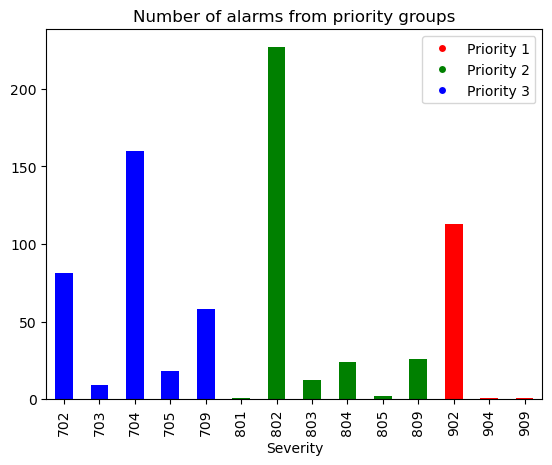

In [126]:
priority_colors = np.array([assign_color(pri) for pri in priority_count.index])
ax = priority_count.plot(kind="bar", title="Number of alarms from priority groups",
                           color=priority_colors[:,1])

unique_pri = np.unique(priority_colors, axis=0)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Priority {pri[0]}', markerfacecolor=col) for pri, col in zip(unique_pri[:,0], unique_pri[:,1])]
ax.legend(handles=legend_elements)

plt.show()

In [127]:
alarm_events["time"] = pd.to_datetime(alarm_events["start_time"], unit="ms").values
alarm_events["time"] = alarm_events["time"] + timedelta(hours=hours_offset) # Convert to time zone used in source system (NB: 2 hours for summer time!)
alarm_events = alarm_events.set_index("time").sort_index()

### 3. Group by priority

In [128]:
alarm_events_10min = alarm_events.resample("10T")
all_10mins = alarm_events_10min.count().index

alarms2tag = alarm_events_10min["SourceName"].value_counts() # tags for alarms for each 10 min frame

In [129]:
num_alarms_10min = alarm_events.groupby(pri_col).resample("10T").count()["external_id"]
num_alarms_10min = pd.DataFrame(num_alarms_10min, index=num_alarms_10min.index).sort_index(level="time")
num_alarms_10min = num_alarms_10min.rename(columns={"external_id":"count"})

### 4. Make table counting number of pri 1, 2 and 3 alarms each 10 min slot

In [130]:
num_alarms = pd.DataFrame(index=all_10mins)

num_alarms = num_alarms.reset_index()
num_alarms = num_alarms.rename(columns={"time":"start_time"})
num_alarms["end_time"] = num_alarms["start_time"] + timedelta(minutes=10)

for pri in [1,2,3]:
    num_alarms[f"priority {pri}"] = np.zeros(len(all_10mins))
    num_pri_alarms = num_alarms_10min[num_alarms_10min.index.get_level_values(pri_col) == pri]["count"]
    time_index = num_alarms_10min.index.get_level_values("time").unique()
    pri_index = time_index[time_index.isin(num_pri_alarms.index.get_level_values("time"))] # unique to omit duplicates from multiindex
    num_alarms.loc[num_alarms["start_time"].isin(pri_index), f"priority {pri}"] = num_pri_alarms.values

    num_alarms[f"priority {pri}"].replace(np.nan, 0, inplace=True) # NaN means no alarms for this priority
    num_alarms[f"priority {pri}"] = num_alarms[f"priority {pri}"].astype(int) # from string to int

    num_alarms[f"pri{pri} / min"] = num_alarms[f"priority {pri}"]/10 # number of alarms of this priority per min for given 10 min period

    num_alarms[f"% of total pri{pri}"] = round(num_alarms[f"priority {pri}"]/num_alarms[f"priority {pri}"].sum()*100, 2) # percentage of all priority "pri" alarms last 12 hours occurred during 10 min period

num_alarms = num_alarms.set_index("start_time")
num_alarms.head()
# now = pd.Timestamp.now()
# now_date = str(now.date()) + "_" + str(now.hour) + "h" + str(now.minute) + "m" + str(now.second) + "s"
# num_alarms.to_csv(f"../data/output/num_alarms/last12hours_{now_date}.csv")

,end_time,priority 1,pri1 / min,% of total pri1,priority 2,pri2 / min,% of total pri2,priority 3,pri3 / min,% of total pri3
start_time,,,,,,,,,,
2023-11-02 12:00:00,2023-11-02 12:10:00,0,0.0,0.0,14,1.4,4.79,1,0.1,0.31
2023-11-02 12:10:00,2023-11-02 12:20:00,0,0.0,0.0,5,0.5,1.71,8,0.8,2.45
2023-11-02 12:20:00,2023-11-02 12:30:00,0,0.0,0.0,10,1.0,3.42,2,0.2,0.61
2023-11-02 12:30:00,2023-11-02 12:40:00,0,0.0,0.0,7,0.7,2.40,5,0.5,1.53
2023-11-02 12:40:00,2023-11-02 12:50:00,0,0.0,0.0,3,0.3,1.03,2,0.2,0.61


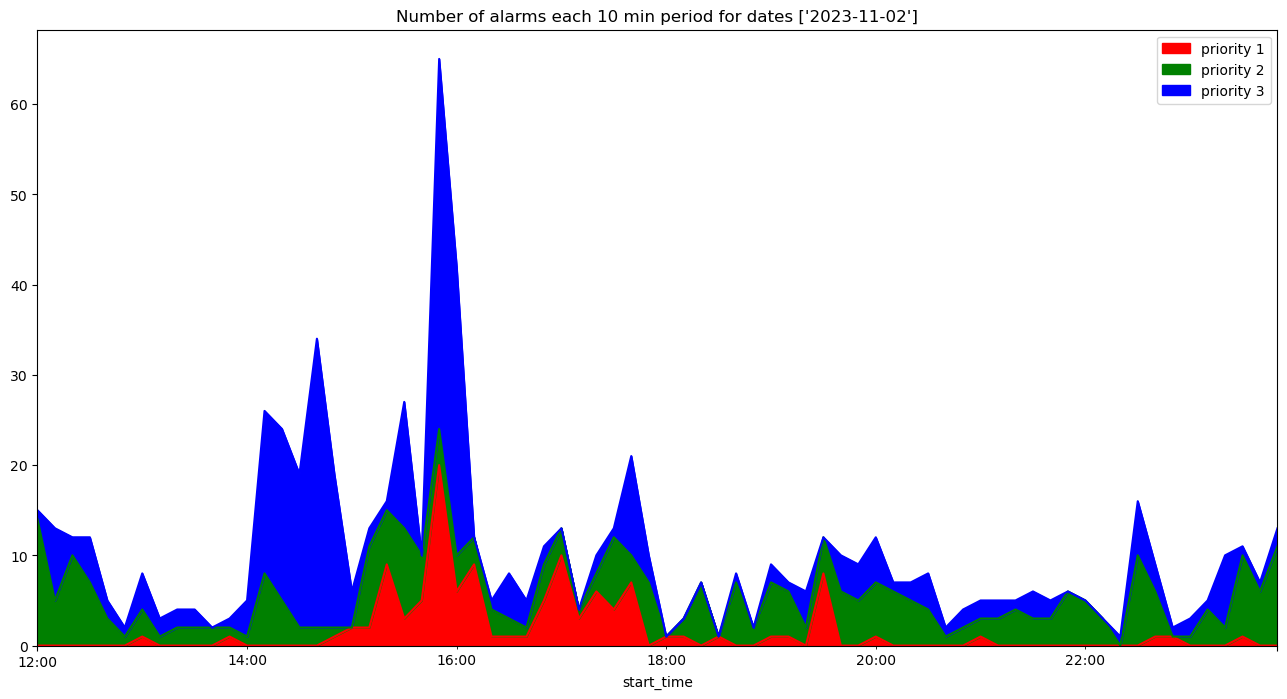

In [131]:
unique_dates = np.unique(num_alarms.index.date)

num_alarms[["priority 1", "priority 2", "priority 3"]].plot.area(stacked=True,
                                                            figsize=[16,8], color=["r", "g", "b"],
                                                            title=f"Number of alarms each 10 min period for dates {[str(d) for d in unique_dates]}")

plt.show()

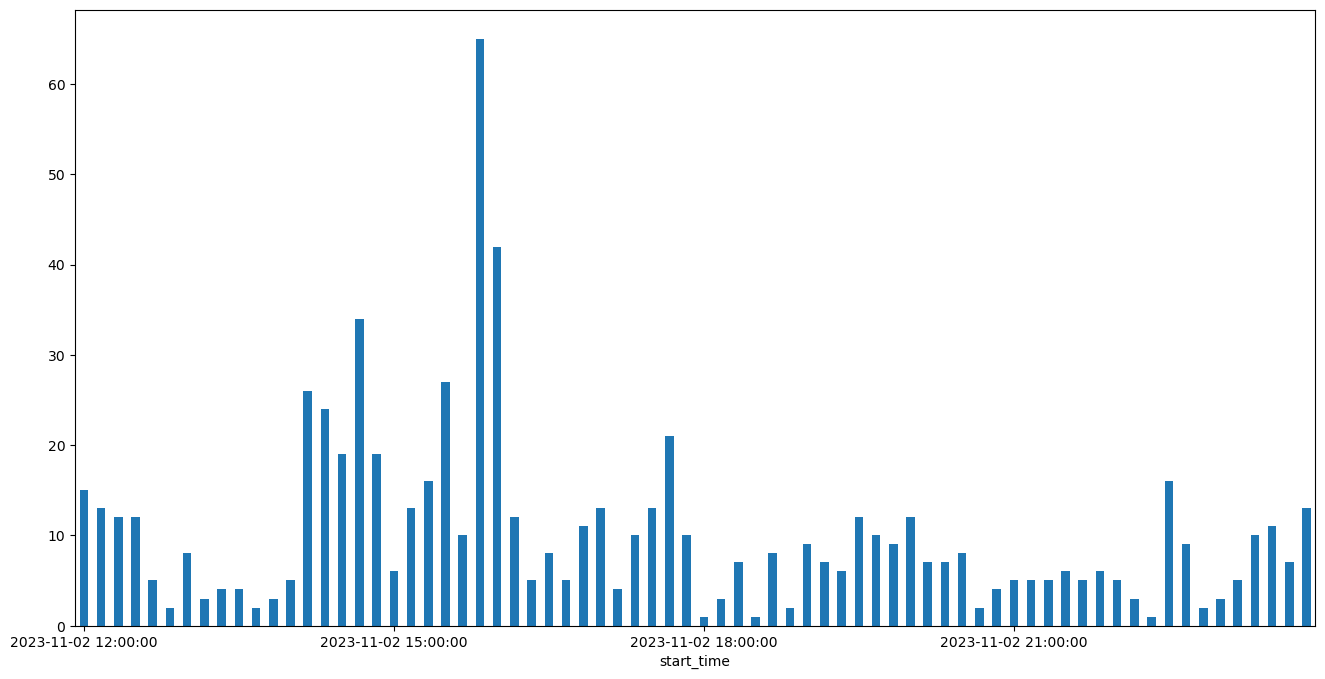

In [132]:
fig, ax = plt.subplots()
num_alarms[["priority 1", "priority 2", "priority 3"]].sum(axis=1).plot.bar(figsize=[16,8], ax=ax)
xtick_pos = np.arange(0, len(num_alarms), int(len(num_alarms)/4))
xtick_lab = num_alarms.index[::int(len(num_alarms)/4)]
plt.xticks(xtick_pos, xtick_lab, rotation=0)
# ax.set_xticks(num_alarms.index)
plt.show()

In [133]:
true_date = end_date + timedelta(hours=hours_offset) # Convert back to actual date specified in ABB
YYYY = true_date.year
MM = f"0{str(true_date.month)}" if len(str(true_date.month)) == 1 else true_date.month
DD = f"0{str(true_date.day)}" if len(str(true_date.day)) == 1 else true_date.day
abb_pri123_alarms = pd.read_excel(f"../data/Alarm Analysis - Initiated Alarms_{YYYY}{MM}{DD}.xlsx", sheet_name="Data", usecols=["Start Time", "Stop Time", "Number of alarms"])

In [134]:
num_alarms["CDF"] = num_alarms[["priority 1", "priority 2", "priority 3"]].sum(axis=1)
num_alarms["ABB"] = abb_pri123_alarms["Number of alarms"].values

In [135]:
deviation = num_alarms["CDF"] != num_alarms["ABB"]
alarms_deviation = num_alarms[deviation][["CDF", "ABB"]]
alarms_deviation

,CDF,ABB
start_time,,
2023-11-02 14:00:00,5,6
2023-11-02 14:50:00,19,20
2023-11-02 15:00:00,6,5
2023-11-02 15:10:00,13,11
2023-11-02 15:20:00,16,13
2023-11-02 15:40:00,10,11
2023-11-02 15:50:00,65,105
2023-11-02 16:00:00,42,43
2023-11-02 16:40:00,5,4


In [144]:
alarms2tag[alarms2tag.index.get_level_values("time") == alarms_deviation.index[2]]
# alarms2tag[alarms2tag.index.get_level_values("time") == "2023-10-31 18:50:00"]


time                 SourceName      
2023-11-02 15:00:00  19-ZT-111151        2
                     49-XS-97614-02      2
                     65-PIC-91726        1
                     49-FE-G-I15-045R    1
Name: count, dtype: int64

In [137]:
# test_df[test_df["SourceName"] == "x49_NXI_84080"]["EventData"].iloc[2]
with pd.ExcelWriter(f"../data/alarms2tag_{YYYY}{MM}{DD}.xlsx") as writer:
    alarms_deviation.to_excel(writer, sheet_name="Alarms deviation")

    for i in range(len(alarms_deviation)):
        start_dev = alarms_deviation.index[i]
        end_dev = start_dev + timedelta(minutes=10)
        start_mask = alarm_events.index >= start_dev
        end_mask = alarm_events.index < end_dev
        events_dev = alarm_events[start_mask & end_mask]
        events_dev.to_excel(writer, sheet_name=f"Period {i+1}")

### Get ALL events in 12 hour frame

In [138]:
df_test = client.events.list(data_set_ids=opc_ua_val_id, limit=-1,
                                    start_time={"min":int(start_time_sec), "max":int(end_time_sec)}).to_pandas()

In [139]:
df_test = df_with_metadata(df_test, "metadata")
df_test["EventData"] = df_test["EventData"].apply(lambda x: x.replace("{","").replace("}","").replace("'",""))
df_test["EventData"] = df_test["EventData"].apply(lambda x: ast.literal_eval(x.replace("[","{").replace("]","}")))
df_test = df_with_metadata(df_test, "EventData")

In [140]:
df_test["time"] = pd.to_datetime(df_test["start_time"], unit="ms").values
df_test["time"] = df_test["time"] + timedelta(hours=hours_offset) # Convert to time zone used in source system (NB: 2 hours for summer time!)
df_test = df_test.set_index("time").sort_index()

In [141]:
mask1 = df_test.index > "2023-11-06 12:10:00"
mask2 = df_test.index < "2023-11-06 12:20:00"
mask3 = df_test["Severity"].astype(int) > 699
mask4 = df_test["SourceName"] == "Valhall_F88"
df_test[mask1 & mask2 & mask3][["SourceName", "Severity", "newState", "description", "AlarmState", "Shelved"]].iloc[30:50].T

time
SourceName
Severity
newState
description
AlarmState
Shelved


In [142]:
mask1 = alarm_events.index > "2023-11-02 23:10:00"
mask2 = alarm_events.index < "2023-11-02 23:20:00"
alarm_events[mask1 & mask2][["SourceName", "Severity", "newState", "description", "AlarmState"]].T
# alarm_events["AlarmState"].isna().sum()

time,2023-11-02 23:13:33.267,2023-11-02 23:15:18.596,2023-11-02 23:15:41.977,2023-11-02 23:17:38.977,2023-11-02 23:19:42.887
SourceName,81-LT-80539,65-PDIT-171861,65-FT-89623,65-FT-89623,10-PT-180583
Severity,809,802,802,802,704
newState,3.0,3.0,3.0,3.0,3.0
description,70.00 %,Fault,<= 16352.0 m3/h Warning L,<= 16352.0 m3/h Warning L,<= 100.0 barA Warning L
AlarmState,ACT,ACT,ACT,ACT,ACT


In [143]:
priority_1

[901, 902, 903, 904, 905, 906, 907, 908, 909]